## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,precision_score,recall_score,log_loss,confusion_matrix


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif



In [2]:
def cls_feature(X,max_cat = 10):
        #Agrupando features numéricas
    numeric_features  = [cls for cls in X.columns if X[cls].dtype == 'float64' or X[cls].dtype =='int64']
    # print('>>numeric_features:', numeric_features ,
          # len(numeric_features))


    #Agrupando features categoricas
    categorical_features = [cls for cls in X.columns if X[cls].dtypes == 'object' and X[cls].nunique()<=max_cat]
    # print('\n>>cat_features:', cat_features ,
          # len(cat_features))
    return numeric_features , categorical_features

In [3]:
def print_metrics(y_true, y_pred, y_pred_proba):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred)

    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1-Score: {:.2f}".format(f1))
    print("Log Loss: {:.2f}".format(logloss))
    print("ROC AUC Score: {:.2f}".format(roc_auc))

In [4]:
def feature_importance (model):
    imp_df = pd.DataFrame({
        'Feature Name': X_train.columns,
        'Importance': model.feature_importances_
    })
    fi = imp_df.sort_values(by ='Importance',ascending=False)

    fi2 = fi.head(10)
    plt.figure(figsize=(10,8))
    sns.barplot(data = fi2, x = 'Importance',y = 'Feature Name')
    plt.title('Top 10 Feature Importance para cada Atributo (Random Forest)',fontsize = 18)
    plt.xlabel('Importance',fontsize = 16)
    plt.ylabel('Feature Name',fontsize = 16)
    plt.show()
    return fi2,imp_df

## Data

In [5]:
df = pd.read_csv('data/atual_train_v2.csv')

In [6]:
df

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso,cat_empresa,cat_salario,cat_experiencia,tem_doutorado,tem_mestrado_exp,salario_hora
0,EZYV10567,Europa,Ensino Médio,N,S,2087,1855,Sul,69711.24,Ano,S,Negado,antiga,medio_baixo,3,0,0,0
1,EZYV5505,Ásia,Mestrado,S,N,5991,2003,Meio-Oeste,52931.38,Ano,S,Aprovado,nova,medio_baixo,2,0,1,0
2,EZYV5207,Ásia,Ensino Médio,N,N,1426,2000,Ilha,110830.21,Ano,S,Negado,nova,alto,4,0,0,0
3,EZYV7545,Ásia,Ensino Médio,N,N,3846,1992,Meio-Oeste,91884.68,Semana,S,Negado,intermediaria,medio_alto,4,0,0,0
4,EZYV16071,Ásia,Ensino Superior,S,N,3957,1949,Nordeste,138155.24,Ano,S,Aprovado,intermediaria,alto,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17831,EZYV17821,Ásia,Mestrado,S,N,95347,1995,Oeste,69692.24,Ano,S,Aprovado,intermediaria,medio_baixo,2,0,1,0
17832,EZYV13200,Europa,Ensino Médio,N,N,1483,1886,Sul,136237.62,Ano,S,Negado,antiga,alto,4,0,0,0
17833,EZYV8903,América do Norte,Mestrado,N,N,1504,2010,Nordeste,118187.30,Ano,S,Negado,nova,alto,4,0,0,0
17834,EZYV6163,América do Norte,Doutorado,S,N,251967,2010,Meio-Oeste,93133.40,Ano,S,Aprovado,nova,medio_alto,2,1,0,0


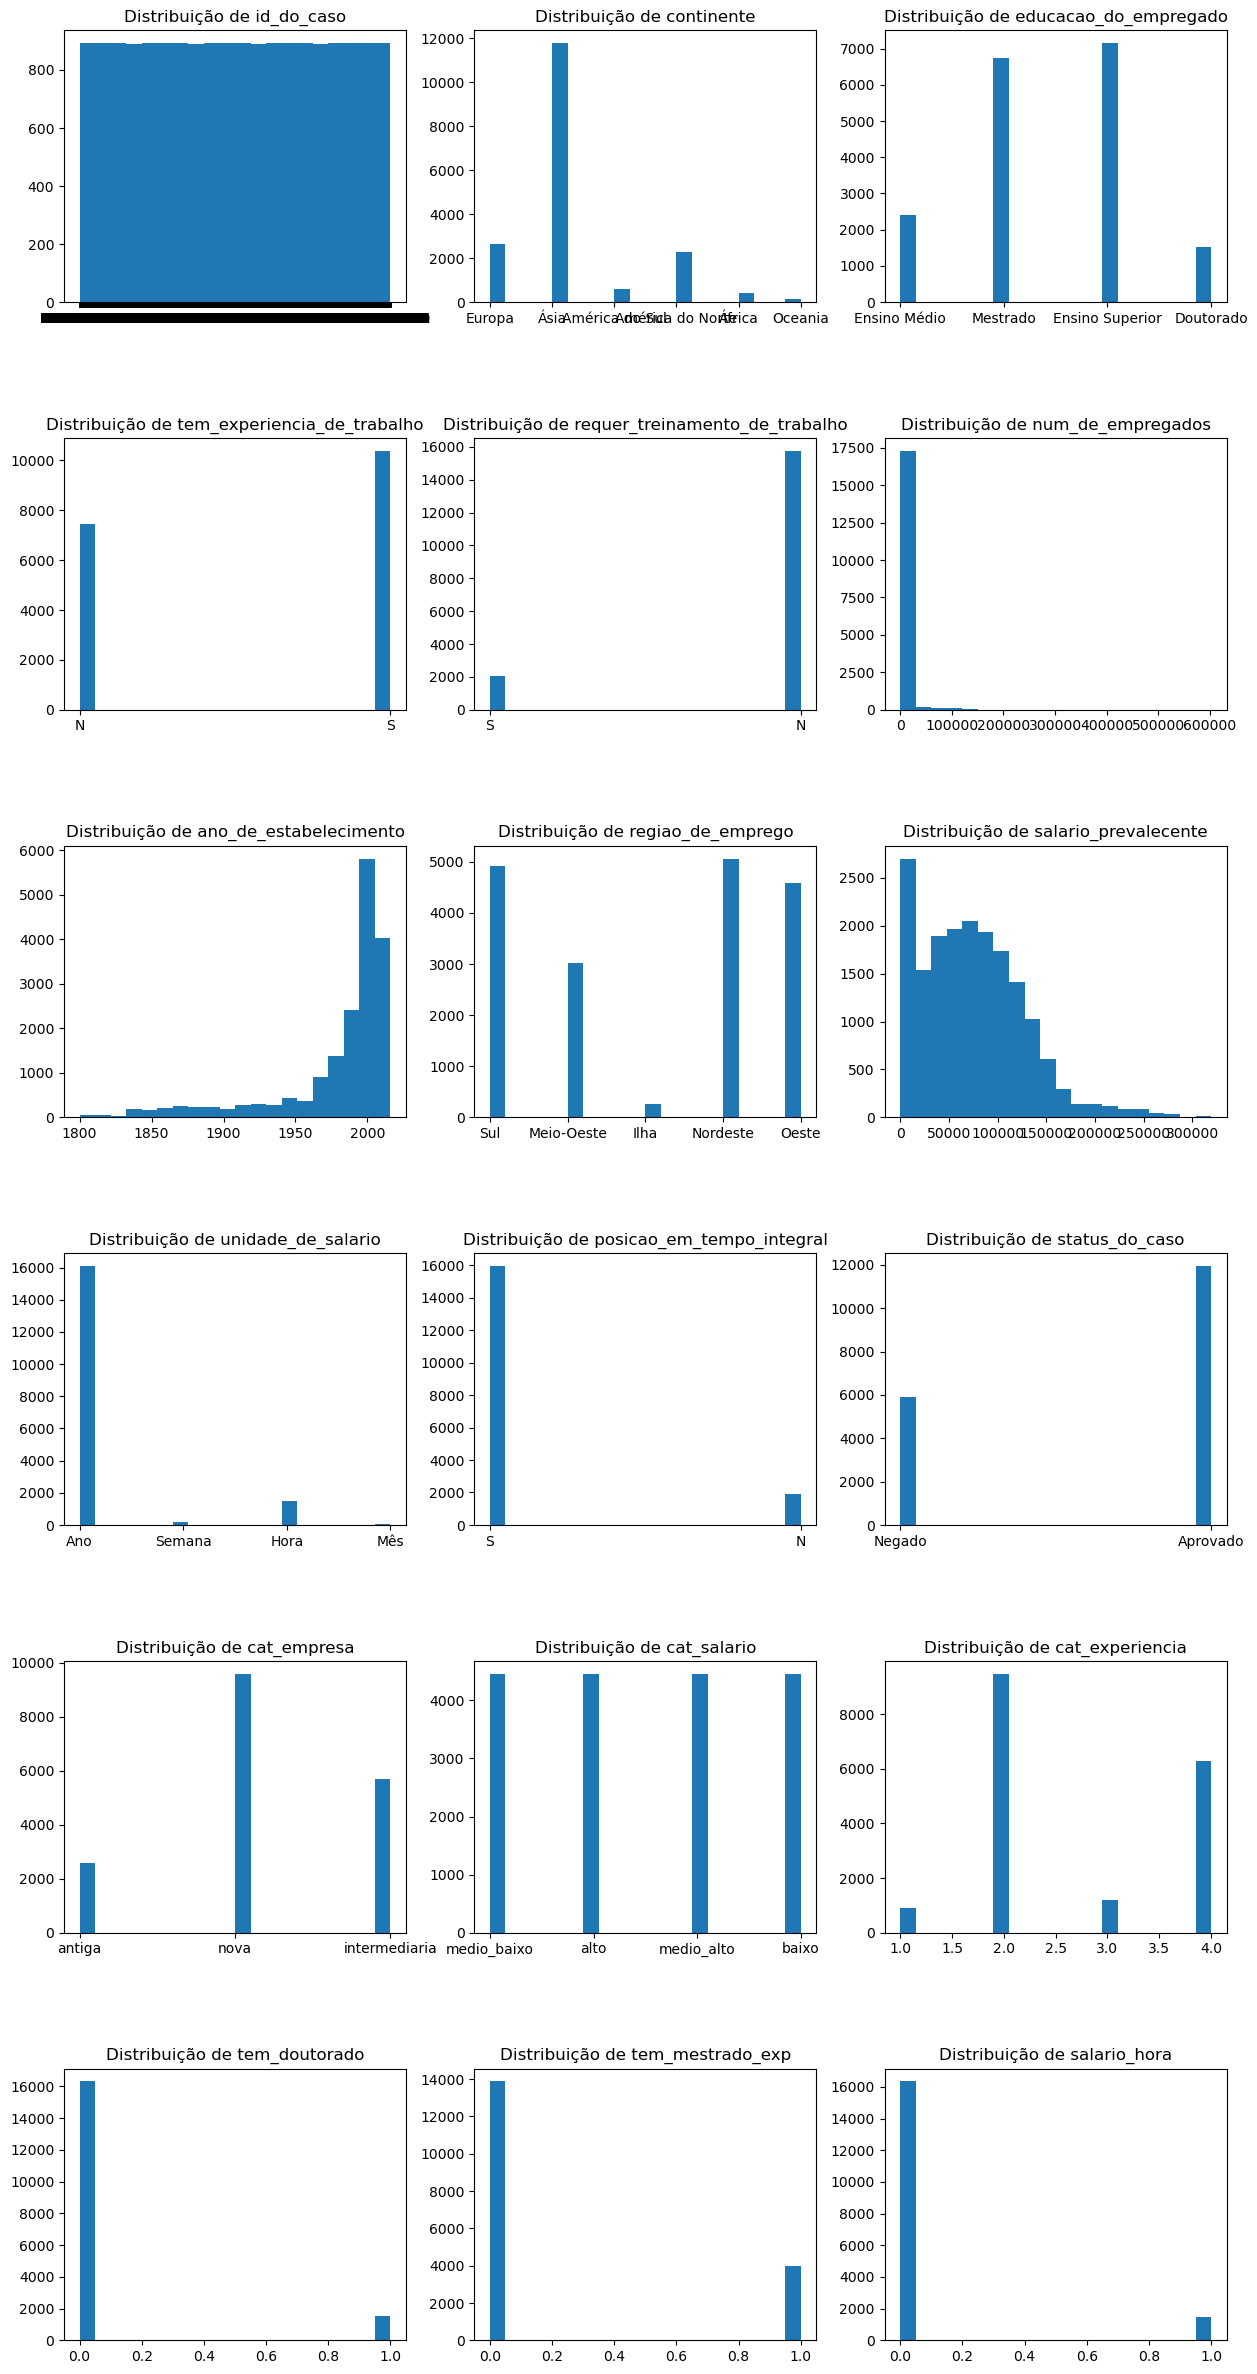

In [17]:
dataset = df # Substitua 'seu_dataset.csv' pelo nome do seu arquivo CSV

# Configurações dos subplots
num_cols = 3
num_rows = -(-len(dataset.columns) // num_cols)  # Cálculo para arredondar para cima a divisão de colunas por 3
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.5)

# Plotar a distribuição de todas as variáveis
for i, column in enumerate(dataset.columns):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].hist(dataset[column], bins=20)
    axs[row, col].set_title(f'Distribuição de {column}')

# Remover subplots vazios, se houver
if len(dataset.columns) % num_cols != 0:
    for j in range(len(dataset.columns) % num_cols, num_cols):
        axs[num_rows-1, j].axis('off')

plt.show()

## Start

In [7]:
df['status_do_caso'].value_counts()

Aprovado    11937
Negado       5899
Name: status_do_caso, dtype: int64

In [8]:
df['status_do_caso'] = df['status_do_caso'].apply(lambda x: 1 if x == 'Aprovado' else 0)

In [9]:
df['status_do_caso'].value_counts()

1    11937
0     5899
Name: status_do_caso, dtype: int64

In [10]:
df.dtypes

id_do_caso                         object
continente                         object
educacao_do_empregado              object
tem_experiencia_de_trabalho        object
requer_treinamento_de_trabalho     object
num_de_empregados                   int64
ano_de_estabelecimento              int64
regiao_de_emprego                  object
salario_prevalecente              float64
unidade_de_salario                 object
posicao_em_tempo_integral          object
status_do_caso                      int64
cat_empresa                        object
cat_salario                        object
cat_experiencia                     int64
tem_doutorado                       int64
tem_mestrado_exp                    int64
salario_hora                        int64
dtype: object

In [11]:
for col in ['cat_experiencia','tem_doutorado','tem_mestrado_exp','salario_hora']:
    df[col] =df[col].astype('object')

In [13]:
df.dtypes

id_do_caso                         object
continente                         object
educacao_do_empregado              object
tem_experiencia_de_trabalho        object
requer_treinamento_de_trabalho     object
num_de_empregados                   int64
ano_de_estabelecimento              int64
regiao_de_emprego                  object
salario_prevalecente              float64
unidade_de_salario                 object
posicao_em_tempo_integral          object
status_do_caso                      int64
cat_empresa                        object
cat_salario                        object
cat_experiencia                    object
tem_doutorado                      object
tem_mestrado_exp                   object
salario_hora                       object
dtype: object

In [14]:
X = df.drop(columns=['id_do_caso','status_do_caso'])
y = df['status_do_caso']

In [15]:
numeric_features , categorical_features = cls_feature(X)

In [16]:
numeric_features

['num_de_empregados', 'ano_de_estabelecimento', 'salario_prevalecente']

In [26]:
categorical_features

['continente',
 'educacao_do_empregado',
 'tem_experiencia_de_trabalho',
 'requer_treinamento_de_trabalho',
 'regiao_de_emprego',
 'unidade_de_salario',
 'posicao_em_tempo_integral',
 'cat_empresa',
 'cat_salario',
 'cat_experiencia',
 'tem_doutorado',
 'tem_mestrado_exp',
 'salario_hora']

In [31]:
ordinal_features = ['educacao_do_empregado','cat_empresa','cat_salario','cat_experiencia','unidade_de_salario']

In [32]:
nominal_features = [feature for feature in categorical_features if feature not in ordinal_features]


In [34]:
print("Variáveis Ordinais:")
print(ordinal_features, len(ordinal_features))

print("\nVariáveis Nominais:")
print(nominal_features,len (nominal_features))

Variáveis Ordinais:
['educacao_do_empregado', 'cat_empresa', 'cat_salario', 'cat_experiencia', 'unidade_de_salario'] 5

Variáveis Nominais:
['continente', 'tem_experiencia_de_trabalho', 'requer_treinamento_de_trabalho', 'regiao_de_emprego', 'posicao_em_tempo_integral', 'tem_doutorado', 'tem_mestrado_exp', 'salario_hora'] 8


In [ ]:
f_ckass

## Prepro

In [56]:
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #MODA
    ('onehot', OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #MODA
    ('ordinal', OrdinalEncoder())
])

numerical_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numerical_transformer, numeric_features),
                    ('cat_nom', nominal_transformer, nominal_features),
                    ('ord_nom', ordinal_transformer, ordinal_features)
                ])



In [57]:
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('rf_model', RandomForestClassifier(n_estimators=100,max_depth=10,random_state=0,class_weight='balanced'))
    
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num_de_empregados',
                                                   'ano_de_estabelecimento',
                                                   'salario_prevalecente']),
                                                 ('cat_nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
              

In [58]:
from sklearn.metrics import accuracy_score


resultados = []
# Defina o número de folds
k = 5

# Crie uma instância do KFold
kf = KFold(n_splits=k, shuffle=True,random_state=42)

# Loop através dos folds
for train_index, test_index in kf.split(X):
    print('Treino:',train_index)
    print('Validação,',test_index)
    # Divida os dados em conjuntos de treinamento e teste
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Crie e ajuste o pipeline aos dados de treinamento
    model = pipeline.fit(X_train, y_train)
    
    # Faça as previsões nos dados de teste
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_log_proba(X_test)
    

Treino: [    1     2     4 ... 17832 17833 17835]
Validação, [    0     3     5 ... 17829 17831 17834]
Treino: [    0     1     2 ... 17833 17834 17835]
Validação, [   15    17    20 ... 17813 17823 17824]
Treino: [    0     1     2 ... 17833 17834 17835]
Validação, [    4    10    12 ... 17814 17820 17832]
Treino: [    0     3     4 ... 17833 17834 17835]
Validação, [    1     2    18 ... 17827 17828 17830]
Treino: [    0     1     2 ... 17831 17832 17834]
Validação, [    6     7     9 ... 17822 17833 17835]


Accuracy: 0.72
Precision: 0.83
Recall: 0.73
F1-Score: 0.78
Log Loss: 0.69
ROC AUC Score: 0.71


In [59]:
print_metrics(y_test,y_pred,y_pred_proba)

Accuracy: 0.72
Precision: 0.83
Recall: 0.73
F1-Score: 0.78
Log Loss: 0.69
ROC AUC Score: 0.71


In [60]:
scores = cross_val_score(
    model,    # classificador
    X_train,          # dados treino
    y_train,          # dados teste
    cv=5,             # numero de folds
    scoring='roc_auc' # métrica avaliação
)

print("ROC_AUC score:\n", np.mean(scores))

ROC_AUC score:
 0.7758003769551876
